# Reproducing "Deep Bayesian Active Learning with Image Data"

Imports

In [ ]:
# PyTorch
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset, DataLoader

# Other
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import sys

Constants

In [ ]:
T = 20
NUM_CLASSES = 10
EPOCHS = 50
INIT_TRAIN_SIZE = 20
VALID_SIZE = 100
BATCH_SIZE = 128
POOL_BATCH_SIZE = 128
SUBPOOL_SIZE = 10_000
EPSILON = sys.float_info.min
ACQ_SIZE = 10
ACQ_STEPS = 100
REPS = 3
CPU = "cpu"
CUDA = "cuda"
DEVICE = torch.device(CUDA if torch.cuda.is_available() else CPU)
WDS = [
    0.5e-2, 1e-2,
    0.5e-3, 1e-3,
    0.5e-4, 1e-4,
    0.5e-5, 1e-5,
    0.5e-6, 1e-6
]
NUM_WORKERS = 2


Load MNIST Dataset

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

print(f'\ntrain data size: {len(dataset)}')
print(f'test data size: {len(test_dataset)}')

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.47MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 128kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.90MB/s]


train data size: 60000
test data size: 10000


Neural Net

In [ ]:
class BCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fwd = nn.Sequential(
            # shape 1,28,28
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=4),
            nn.ReLU(),
            # shape 32,25,25
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4),
            nn.ReLU(),
            # shape 32,22,22
            nn.MaxPool2d(2, 2),
            # shape 32,11,11
            nn.Dropout(p=0.25),
            nn.Flatten(),
            nn.Linear(32*11*11, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, NUM_CLASSES),
            # Criterion expects raw logits, so no softmax
        )

    def forward(self, x):
        return self.fwd(x)

In [ ]:
def mc_dropout(model):
  for module in model.modules():
      if isinstance(module, nn.Dropout):
        module.train()

In [ ]:
def test_model(model, test_loader, mc):
  correct = 0
  total = 0
  T_eff = 1

  # put model in eval mode
  model.eval()
  if mc:
    mc_dropout(model)
    T_eff = T

  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for images, labels in test_loader:
          images = images.to(DEVICE)
          labels = labels.to(DEVICE)

          # multiple forward passes
          t_outputs = []
          for _ in range(T_eff):
            outputs = model(images)
            outputs = F.softmax(outputs, dim=1)
            # unsqueeze to add extra dimension
            t_outputs.append(outputs.unsqueeze(0))
          # concat t's
          t_outputs = torch.cat(t_outputs, dim=0)


          # average across t's
          mean_output = torch.mean(t_outputs, dim=0)

          _, predicted = torch.max(mean_output, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  return accuracy

In [ ]:
def train_model(train_loader, valid_loader, wd, mc):
  model = BCNN().to(DEVICE)

  # not specified in paper so use example reference
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), weight_decay=wd)

  for epoch in range(EPOCHS):
    model.train()
    for i, data in enumerate(train_loader, 0):
          inputs, labels = data
          inputs = inputs.to(DEVICE)
          labels = labels.to(DEVICE)
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

  return model

Active Learning

In [ ]:
def pool_predictions(model, pool_loader, mc):
  T_eff = 1

  # put model in eval mode
  model.eval()
  if mc:
    mc_dropout(model)
    T_eff = T

  with torch.no_grad():
      for images, labels in pool_loader:
          images = images.to(DEVICE)
          labels = labels.to(DEVICE)

          # multiple forward passes
          t_outputs = []
          for _ in range(T_eff):
            outputs = model(images)
            outputs = F.softmax(outputs, dim=1)
            # unsqueeze to add extra dimension
            t_outputs.append(outputs.unsqueeze(0))
          # concat t's
          t_outputs = torch.cat(t_outputs, dim=0)

          yield t_outputs

def max_entropy(model, pool_loader, mc):
  scores = []
  # t_ouputs: (T, batch_size, c)
  for t_outputs in pool_predictions(model, pool_loader, mc=mc):
    # (batch_size, c)
    mean_pct = torch.mean(t_outputs, dim=0)
    mulogmu = mean_pct * torch.log(mean_pct + EPSILON)
    # (batch_size)
    batch_scores = - torch.sum(mulogmu, dim=1)

    scores.append(batch_scores)

  scores = torch.cat(scores)
  top_scores, top_indices = torch.topk(scores, ACQ_SIZE)

  return top_scores, top_indices

def bald(model, pool_loader, mc):
  scores = []
  # t_ouputs: (T, batch_size, c)
  for t_outputs in pool_predictions(model, pool_loader, mc=mc):
    # (batch_size, c)
    mean_pct = torch.mean(t_outputs, dim=0)
    mulogmu = mean_pct * torch.log(mean_pct + EPSILON)
    # (batch_size)
    first_term = torch.sum(mulogmu, dim=1)

    # (T, batch_size, c)
    plogp = t_outputs * torch.log(t_outputs + EPSILON)
    # (T, batch_size)
    sum_c = torch.sum(plogp, dim=2)
    # (batch_size)
    second_term = torch.mean(sum_c, dim=0)

    batch_scores = - first_term + second_term
    scores.append(batch_scores)

  scores = torch.cat(scores)
  top_scores, top_indices = torch.topk(scores, ACQ_SIZE)

  return top_scores, top_indices

def vr(model, pool_loader, mc):
  scores = []
  # t_ouputs: (T, batch_size, c)
  for t_outputs in pool_predictions(model, pool_loader, mc=mc):
    # (T, batch_size)
    predictions = torch.argmax(t_outputs, dim=2)
    # (batch_size)
    modes, _ = torch.mode(predictions, dim=0)
    # (T, batch_size) <== (T, batch_size) == (1, batch_size)
    mask = (predictions == torch.unsqueeze(modes, dim=0))
    # (batch_size)
    counts = torch.sum(mask, dim=0)
    batch_scores = 1.0 - (counts/t_outputs.size(dim=0))

    scores.append(batch_scores)

  scores = torch.cat(scores)
  top_scores, top_indices = torch.topk(scores, ACQ_SIZE)

  return top_scores, top_indices

def mean_std(model, pool_loader, mc):
  scores = []
  # t_ouputs: (T, batch_size, c)
  for t_outputs in pool_predictions(model, pool_loader, mc=mc):
    squared = t_outputs ** 2
    # (batch_size, c)
    mean_pct = torch.mean(t_outputs, dim=0)
    mean_pct_sq = torch.mean(squared, dim=0)
    var = mean_pct_sq - mean_pct**2
    # Ensure no values < 0
    var = torch.clamp(var, min=0)
    std = torch.sqrt(var)

    batch_scores = torch.mean(std, dim=1)
    scores.append(batch_scores)

  scores = torch.cat(scores)
  top_scores, top_indices = torch.topk(scores, ACQ_SIZE)

  return top_scores, top_indices

def baseline(model, pool_loader, mc):
  pool_size = len(pool_loader.dataset)
  top_scores = torch.zeros(pool_size)
  top_indices = torch.randperm(pool_size)[:ACQ_SIZE]

  return top_scores, top_indices

Experiments  

In [ ]:
def exp1(a_func, mc):
  results = []

  # set up initial random but balanced training set
  gen = torch.Generator().manual_seed(42)
  N = len(dataset)
  pool_size = N - VALID_SIZE

  train_indices = []
  targets = dataset.targets
  for c in range(NUM_CLASSES):
    indices = (targets == c).nonzero(as_tuple=True)[0]
    shuffled = indices[torch.randperm(len(indices), generator=gen)]
    train_indices.extend(shuffled.tolist()[:(INIT_TRAIN_SIZE//10)])

  remaining_indices = list(set(range(N)) - set(train_indices))
  remaining_indices = torch.tensor(remaining_indices)[
      torch.randperm(len(remaining_indices), generator=gen)
  ]

  valid_indices = remaining_indices[:VALID_SIZE].tolist()
  pool_indices = remaining_indices[VALID_SIZE:].tolist()

  train_subset = Subset(dataset, train_indices)
  valid_subset = Subset(dataset, valid_indices)

  train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)
  valid_loader = DataLoader(valid_subset, batch_size=BATCH_SIZE, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

  # hyperparameter optimisation using grid search
  wdc = None
  best_acc = -1
  bcnn = None
  for candidate in WDS:
    curr_bcnn = train_model(train_loader, valid_loader, wd=candidate, mc=mc)
    valid_accuracy = test_model(curr_bcnn, valid_loader, mc=mc)

    if valid_accuracy > best_acc:
      best_acc = valid_accuracy
      wdc = candidate
      bcnn = curr_bcnn

  print(f"Trained Initial Model, Validation Accruacy={best_acc}, WD={wdc}")

  # test initial model
  test_accuracy = test_model(bcnn, test_loader, mc=mc)
  print(f'Initial Test Accuracy: {test_accuracy}%')
  results.append(test_accuracy)

  # active learning
  pbar = tqdm.trange(ACQ_STEPS)
  pbar.set_description("Active Learning")
  pbar_postfix = {}

  for i in pbar:
    pbar_postfix["Status"] = "Running Acq Func"
    pbar.set_postfix(pbar_postfix)

    # use random data points from pool set
    pool_size = len(pool_indices)
    subpool_size = min(pool_size, SUBPOOL_SIZE)
    rand_subpool_idxs = torch.randperm(pool_size)[:subpool_size]
    subpool_idxs = torch.tensor(pool_indices)[rand_subpool_idxs].tolist()
    subpool_subset = Subset(dataset, subpool_idxs)
    subpool_loader = DataLoader(subpool_subset, batch_size=POOL_BATCH_SIZE, shuffle=False, pin_memory=True)

    # score using acquisition function
    top_scores, top_indices = a_func(bcnn, subpool_loader, mc=mc)

    # update pool and training data
    acq_tensor = torch.tensor(subpool_idxs)[top_indices.to(CPU)]
    acq_list = acq_tensor.tolist()
    train_indices.extend(acq_list)
    pool_indices = list(set(pool_indices) - set(acq_list))

    train_subset = Subset(dataset, train_indices)
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)

    # train model
    pbar_postfix["Status"] = "Training Model"
    pbar.set_postfix(pbar_postfix)

    wdn = wdc * INIT_TRAIN_SIZE / len(train_indices)
    bcnn = train_model(train_loader, valid_loader, wd=wdn, mc=mc)

    # test model
    pbar_postfix["Status"] = "Testing Model"
    pbar.set_postfix(pbar_postfix)

    test_accuracy = test_model(bcnn, test_loader, mc=mc)
    results.append(test_accuracy)

    pbar_postfix["Acq Step"] = f"{i+1}"
    pbar_postfix["Test Acc"] = f"{test_accuracy}%"
    pbar.set_postfix(pbar_postfix)

  return results

Main

In [ ]:
# run experiment
trials = []
for _ in range(REPS):
  results = exp1(max_entropy, mc=False)
  trials.append(results)

print("\n")
print(trials)

Trained Initial Model, Validation Accruacy=51.0, WD=0.005
Initial Test Accuracy: 53.06%


Active Learning: 100%|██████████| 100/100 [18:03<00:00, 10.84s/it, Status=Testing Model, Acq Step=100, Test Acc=98.09%]


Trained Initial Model, Validation Accruacy=49.0, WD=1e-06
Initial Test Accuracy: 52.9%


Active Learning: 100%|██████████| 100/100 [18:07<00:00, 10.87s/it, Status=Testing Model, Acq Step=100, Test Acc=97.86%]


Trained Initial Model, Validation Accruacy=55.0, WD=0.001
Initial Test Accuracy: 56.06%


Active Learning: 100%|██████████| 100/100 [18:10<00:00, 10.90s/it, Status=Testing Model, Acq Step=100, Test Acc=98.1%]



[[53.06, 55.3, 62.56, 67.65, 72.47, 73.82, 74.65, 75.01, 77.91, 79.07, 81.37, 76.34, 82.49, 85.01, 86.53, 87.82, 89.06, 88.62, 91.35, 90.35, 90.94, 90.98, 92.37, 92.41, 91.65, 92.86, 93.29, 92.98, 94.56, 93.77, 93.57, 95.06, 94.43, 94.75, 94.64, 94.51, 94.87, 92.3, 95.26, 95.59, 95.46, 95.92, 95.46, 95.25, 95.94, 95.61, 95.52, 96.3, 96.39, 96.02, 96.6, 96.83, 96.65, 96.69, 96.26, 97.27, 95.81, 96.41, 96.74, 96.6, 97.3, 96.53, 97.02, 97.28, 97.38, 96.65, 97.47, 97.1, 97.48, 97.36, 97.15, 97.53, 97.35, 97.37, 97.46, 96.44, 97.05, 97.64, 97.55, 97.72, 97.47, 97.57, 97.35, 97.84, 97.54, 97.7, 97.88, 97.77, 97.59, 97.96, 98.07, 98.11, 98.22, 98.09, 98.15, 98.3, 98.26, 97.82, 98.27, 98.01, 98.09], [52.9, 57.01, 60.65, 58.89, 65.45, 67.7, 68.68, 72.91, 69.45, 73.61, 71.58, 73.01, 75.21, 79.6, 83.85, 84.73, 83.06, 83.9, 88.15, 87.68, 91.61, 91.07, 92.83, 93.66, 93.19, 93.84, 93.3, 93.69, 93.48, 93.18, 94.4, 94.25, 94.63, 95.6, 95.39, 95.44, 96.07, 95.99, 96.2, 96.47, 96.06, 96.34, 96.52, 96.

Plot

In [ ]:
# data: list of {"data": [], "label": str, "color": str}
def plot_graph(data, std=False):
  x = [i*ACQ_SIZE for i in range(ACQ_STEPS+1)]

  for line in data:
    y = np.mean(line["data"], axis=0)
    plt.plot(x,y, label=line["label"], color=line["color"])
    if std:
      y_std = np.std(line["data"], axis=0)
      plt.fill_between(x, y - y_std, y + y_std, color=line["color"], alpha=0.2)

  plt.ylim(80.0, 100.0)

  plt.xticks(np.arange(0, 1100, 100))
  plt.yticks(np.arange(80.0, 102.0, 2.0))

  plt.legend(loc='lower right')
  plt.grid(linestyle='--')
  plt.show()

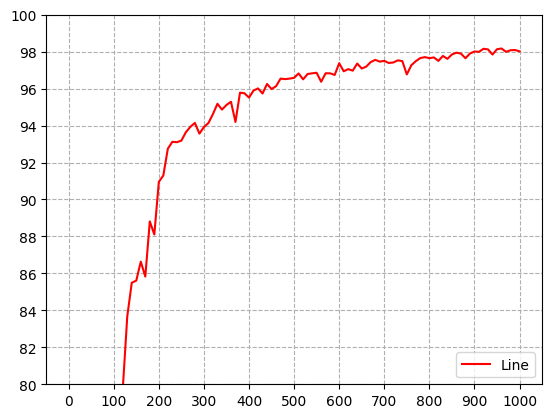

In [ ]:
plot_data = [
    {"data": trials, "label": "Line", "color": "red"},
]

plot_graph(plot_data, std=False)